# Aprendizado de Máquinas: Trabalho Final

In [2]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# metrics
from scipy.stats import pearsonr

# plot configs
sns.set(rc={'figure.figsize':(10,10)});
plt.figure(figsize = (15,15));

<Figure size 1080x1080 with 0 Axes>

## 1. O Dataset

Para a realização deste trabalho foi utilizado o clássico dataset do [titanic](https://www.kaggle.com/competitions/titanic).

### 1.1 Importando os Dados

In [3]:
# import the train data
train = pd.read_csv('data/train.csv')

# import the test data
test = pd.read_csv('data/test.csv')
# import the dataset with the classes
gender = pd.read_csv('data/gender_submission.csv')
# merge the test data with it's classes
test = pd.merge(test, gender, on='PassengerId')

# merge the train and test data to make the analysis
merged_df = train.append(test, ignore_index=True).set_index('PassengerId')
merged_df.tail()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1305,0,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1308,0,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
1309,0,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [4]:
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  1309 non-null   int64  
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB
None


In [5]:
merged_df.dtypes.value_counts()

object     5
int64      4
float64    2
dtype: int64

### 1.2. Preparação dos Dados para a Análise Exploratória

Inicialmente, foi removida coluna `Name` já que como é uma label, quase que análoga ao `PassengerId`, não será de muito uso para o modelo. Com um tratamento avançado seria possível tentar relacionar o sobrenome à família da pessoa. Porém há o caso de pessoas com o mesmo sobrenome advindas de famílias diferentes que não seria possível tratar.

In [6]:
merged_df = merged_df.drop('Name', axis=1)

Outra questão importante é a idade, que possui $263$ valores faltantes. Inicialmente para lidar com estes casos irei simplesmente substituir tais valores pela média de idade dos passageiros.

Mean Age of the Passengers: 29.881137667304014


<AxesSubplot:ylabel='Frequency'>

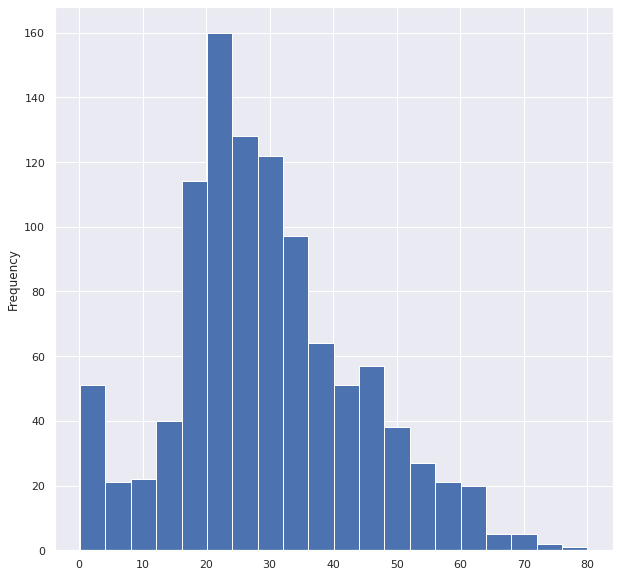

In [7]:
print(f'Mean Age of the Passengers: {merged_df["Age"].mean()}')
merged_df['Age'].plot(kind = 'hist', bins = 20)

In [8]:
merged_df['Age'] = merged_df['Age'].fillna(round(merged_df['Age'].mean(), 0))

A coluna `Embarked` possui 2 valores faltantes, portanto irei utilzar a moda da mesma para tratar destes valores. Como a moda é um valor extremamente mais frequente do que os demais, tal substituição não terá um impacto significativo na performance do modelo já que, provavelmente, os dois passageiros realmente embarcaram no porto de Southampton.

Moda da coluna de Embarque: S
Embarked
S    914
C    270
Q    123
dtype: int64


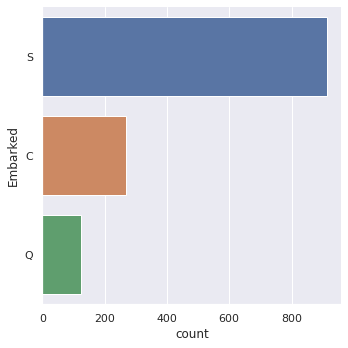

In [9]:
# calculate the mode
embarked_mode = merged_df['Embarked'].mode()
print(f'Moda da coluna de Embarque: {embarked_mode[0]}')
print(f'{merged_df.value_counts("Embarked")}')

# plot a barplot with the counts of each class
sns.catplot(data = merged_df, y = 'Embarked', kind = 'count')

# replace the missing values with the mode
merged_df['Embarked'] = merged_df['Embarked'].fillna(embarked_mode[0])

A última coluna a ser tratada é a coluna `Fare`. Tal coluna é extremamente influenciada pela *feature* `Pclass`, ou seja, à classe do passageiro, como pode ser visto no *boxplot* abaixo.

Mean Fare of Pclass 1: 87.51
Median Fare of Pclass 1: 60.0

Mean Fare of Pclass 2: 21.18
Median Fare of Pclass 2: 15.05

Mean Fare of Pclass 3: 13.3
Median Fare of Pclass 3: 8.05



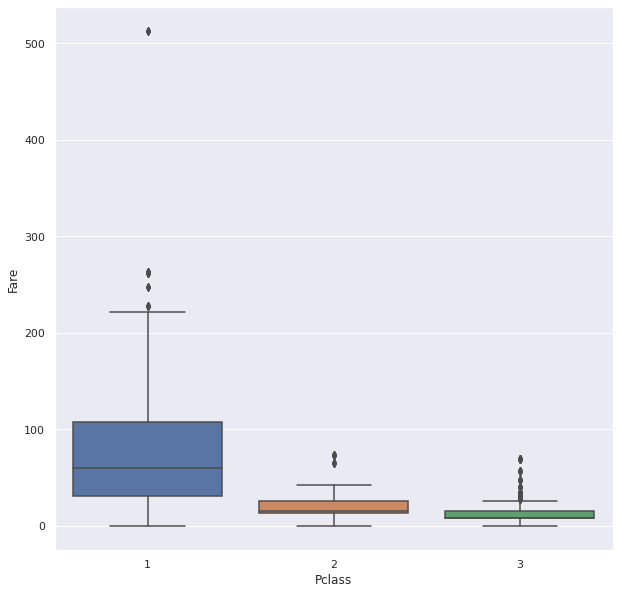

In [10]:
sns.boxplot(data = merged_df, x = 'Pclass', y = 'Fare')

for i in range(3):
    mean = round(merged_df[merged_df['Pclass'] == (i+1)]['Fare'].mean(), 2)
    median = round(merged_df[merged_df['Pclass'] == (i+1)]['Fare'].median(), 2)
    print(f'Mean Fare of Pclass {i+1}: {mean}\nMedian Fare of Pclass {i+1}: {median}\n')

Outra observação importante, é que a média desta classe está sendo muito influenciada por valores extremos, por conta de diferir bastante da mediana, logo utilizarei este segundo valor para preencher o valore faltante.

Como o valor faltante é de classe 3

In [11]:
# replace the missing values with the median of the Pclass 3
merged_df['Fare'] = merged_df['Fare'].fillna(round(merged_df[merged_df['Pclass'] == 3]['Fare'].median(), 2))

Outro problema é o *outlier* com um valor para `Fare` muito extremo, que irei tratar substituindo pela mediana da primeira classe:

In [12]:
merged_df[merged_df['Fare'] > 300]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
259,1,1,female,35.0,0,0,PC 17755,512.3292,NaN,C
680,1,1,male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
738,1,1,male,35.0,0,0,PC 17755,512.3292,B101,C
1235,1,1,female,58.0,0,1,PC 17755,512.3292,B51 B53 B55,C


In [13]:
# change the extreme values to the median of the Pclass 1
merged_df.loc[merged_df.Fare > 300, 'Fare'] = round(merged_df[merged_df['Pclass'] == 1]['Fare'].median(), 2)

Por fim, a coluna cabine possui muitos valores nulos e não é uma coluna que descreve muito bem os dados, logo optei por simplesmente remover ela do dataset. Também a coluna `Ticket` possui mais de 900 valores distintos, então tratar deles tal qual eles estão seria inviável.

In [14]:
# count the Ticket unique values
len(merged_df['Ticket'].unique())

929

In [15]:
merged_df = merged_df.drop('Cabin', axis=1)
merged_df = merged_df.drop('Ticket', axis=1)
merged_df.info()
merged_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  1309 non-null   int64  
 1   Pclass    1309 non-null   int64  
 2   Sex       1309 non-null   object 
 3   Age       1309 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Fare      1309 non-null   float64
 7   Embarked  1309 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 124.3+ KB


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


### 1.3. Tratando os dados categóricos

Primeiro transformei a coluna `Embarked` em *dummies*, ou seja, em 3 colunas binárias, uma para cada um dos pontos de embarque, onde $Embarked_i = 1$, sendo $i=\{C, Q, S\}$, significa que o passageiro embarcou no porto em questão e $Embarked_i=0$ caso contrário.

In [16]:
df_dummies = pd.get_dummies(merged_df, columns=['Embarked'])

Então transformei a coluna `Sex` da mesma forma, porém apenas deixando ela como binário, sendo `male = 1` e `female = 0`:

In [17]:
df_dummies = pd.get_dummies(df_dummies, columns=['Sex'], drop_first = True)

Então o dataset final fica:

In [18]:
df_dummies.info()
print('\n', df_dummies.dtypes.value_counts(), '\n')
df_dummies.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    1309 non-null   int64  
 1   Pclass      1309 non-null   int64  
 2   Age         1309 non-null   float64
 3   SibSp       1309 non-null   int64  
 4   Parch       1309 non-null   int64  
 5   Fare        1309 non-null   float64
 6   Embarked_C  1309 non-null   uint8  
 7   Embarked_Q  1309 non-null   uint8  
 8   Embarked_S  1309 non-null   uint8  
 9   Sex_male    1309 non-null   uint8  
dtypes: float64(2), int64(4), uint8(4)
memory usage: 109.0 KB

 int64      4
uint8      4
float64    2
dtype: int64 



,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_male
PassengerId,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,0,0,1,1
2,1,1,38.0,1,0,71.2833,1,0,0,0
3,1,3,26.0,0,0,7.9250,0,0,1,0
4,1,1,35.0,1,0,53.1000,0,0,1,0
5,0,3,35.0,0,0,8.0500,0,0,1,1
6,0,3,30.0,0,0,8.4583,0,1,0,1
7,0,1,54.0,0,0,51.8625,0,0,1,1
8,0,3,2.0,3,1,21.0750,0,0,1,1
9,1,3,27.0,0,2,11.1333,0,0,1,0


### 1.4. Análise Exploratória

Agora examinando algumas métricas das colunas numéricas:

In [19]:
merged_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,0.377387,2.294882,29.905019,0.498854,0.385027,31.893980
std,0.484918,0.837836,12.883281,1.041658,0.865560,44.450655
min,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,30.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.275000
max,1.000000,3.000000,80.000000,8.000000,9.000000,263.000000


In [20]:
numeric_cols = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

#### Survived
Usando o método `pd.Series.value_counts()` conseguimos ver que o dataset de treino contém dados referentes à $494$ sobreviventes e $815$ pessoas que não sobreviveram.

0    815
1    494
Name: Survived, dtype: int64

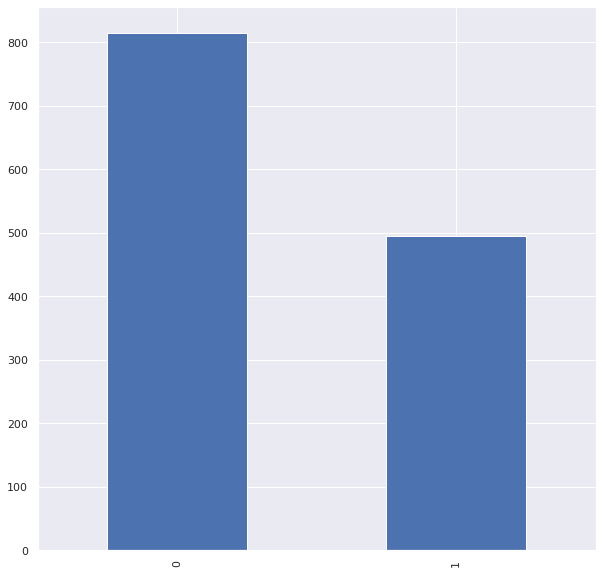

In [21]:
merged_df['Survived'].value_counts().plot(kind='bar')
merged_df['Survived'].value_counts()

#### Boxplot de `Fare` por classe (`PClass`)

<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

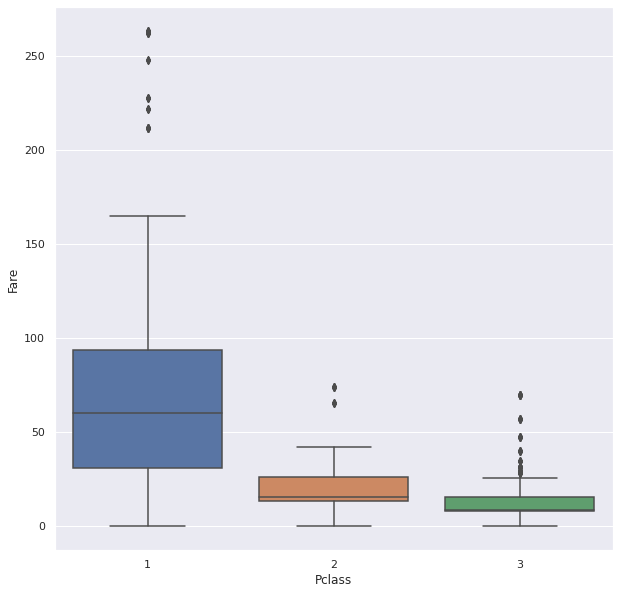

In [22]:
sns.boxplot(data = merged_df, x = 'Pclass', y = 'Fare')

<AxesSubplot:ylabel='Frequency'>

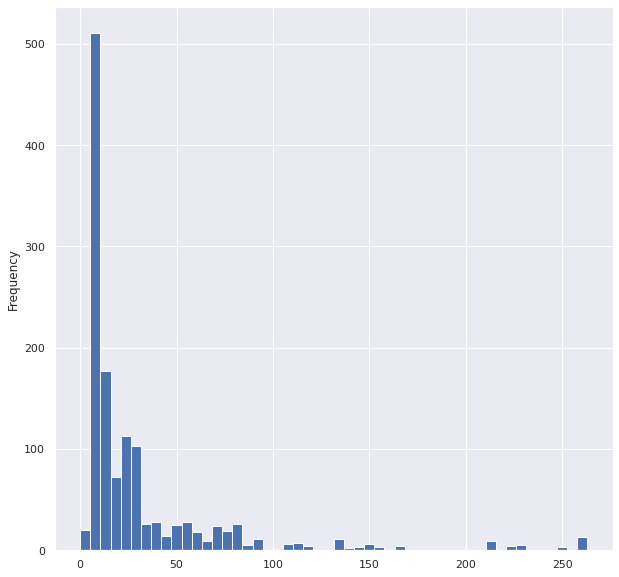

In [23]:
df_dummies['Fare'].plot(kind = 'hist', bins = 50)

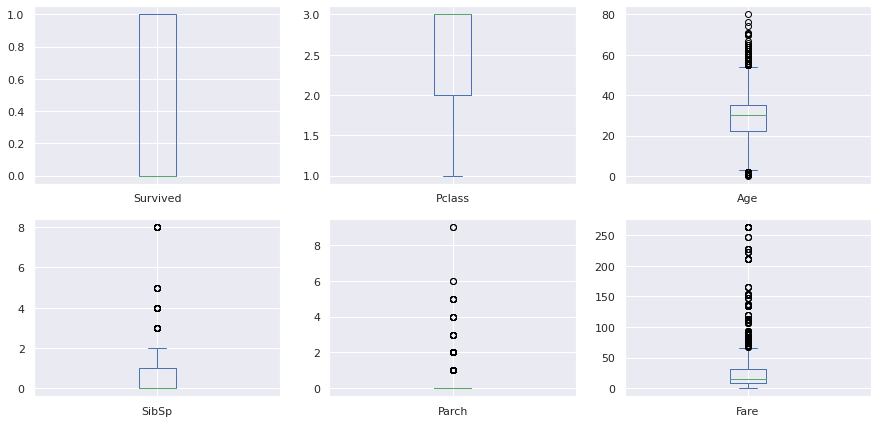

In [24]:
merged_df.plot(kind='box', subplots=True, layout=(4, 3), sharex=False, sharey=False, figsize=(15, 15));

In [25]:
rs = np.random.RandomState(0)

# df = pd.DataFrame(rs.rand(20, 20))
corr = df_dummies.corr()
corr.style.background_gradient(cmap='coolwarm_r')

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_male
Survived,1.000000,-0.264710,-0.048806,0.002370,0.108919,0.232247,0.121156,0.040950,-0.133020,-0.688371
Pclass,-0.264710,1.000000,-0.365598,0.060832,0.018322,-0.602317,-0.269658,0.230491,0.091320,0.124617
Age,-0.048806,-0.365598,1.000000,-0.190774,-0.131174,0.171250,0.076244,-0.011551,-0.059953,0.057627
SibSp,0.002370,0.060832,-0.190774,1.000000,0.373587,0.201606,-0.048396,-0.048678,0.073709,-0.109609
Parch,0.108919,0.018322,-0.131174,0.373587,1.000000,0.253903,-0.008635,-0.100943,0.071881,-0.213125
Fare,0.232247,-0.602317,0.171250,0.201606,0.253903,1.000000,0.272372,-0.141220,-0.150543,-0.206863
Embarked_C,0.121156,-0.269658,0.076244,-0.048396,-0.008635,0.272372,1.000000,-0.164166,-0.778262,-0.066564
Embarked_Q,0.040950,0.230491,-0.011551,-0.048678,-0.100943,-0.141220,-0.164166,1.000000,-0.491656,-0.088651
Embarked_S,-0.133020,0.091320,-0.059953,0.073709,0.071881,-0.150543,-0.778262,-0.491656,1.000000,0.115193
Sex_male,-0.688371,0.124617,0.057627,-0.109609,-0.213125,-0.206863,-0.066564,-0.088651,0.115193,1.000000


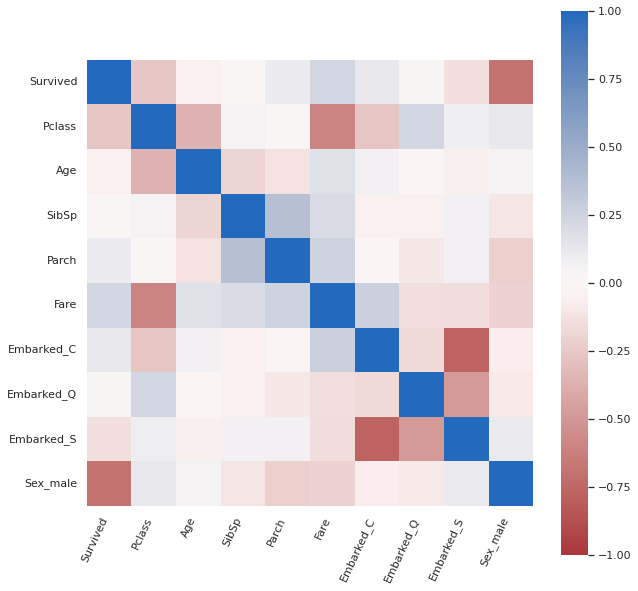

In [26]:
ax = sns.heatmap(   corr, 
                    vmin=-1, vmax=1, center=0, 
                    cmap='vlag_r', #sns.diverging_palette(20, 220, n=200), 
                    square=True
                )
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=65,
    horizontalalignment='right'
);

Fare          0.232247
Embarked_C    0.121156
Parch         0.108919
Embarked_Q    0.040950
SibSp         0.002370
Age          -0.048806
Embarked_S   -0.133020
Pclass       -0.264710
Sex_male     -0.688371
Name: Survived, dtype: float64


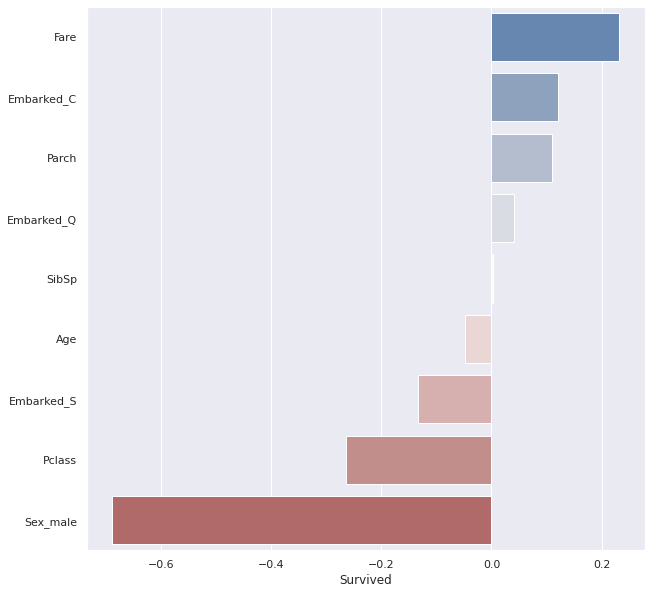

In [27]:
aux_corr = corr['Survived'].drop('Survived')#.sort_values(ascending=False)
aux_corr = aux_corr.sort_values(ascending=False)
print(aux_corr)
sns.barplot(
    x = aux_corr, 
    y = aux_corr.index, 
    palette='vlag');

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


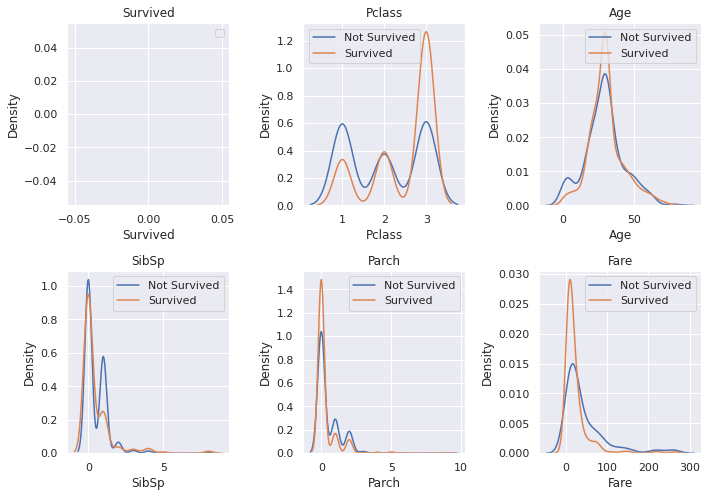

In [28]:
aux_df = merged_df[numeric_cols]

survived = aux_df[aux_df['Survived'] == 1]
not_survived = aux_df[aux_df['Survived'] == 0]

for ax,col in enumerate(aux_df.columns[:9]):
    plt.subplot(3,3, ax + 1)
    plt.title(col)
    sns.kdeplot(x = survived[col], label = "Not Survived", warn_singular = False)
    sns.kdeplot(x = not_survived[col], label = "Survived", warn_singular = False)
    plt.legend()
plt.tight_layout();

## 2. Modelos

In [29]:
# modeling
from sklearn.model_selection import train_test_split
from sklearn import model_selection

# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

import itertools

cv = model_selection.StratifiedKFold(n_splits=20)

### Train Test Split

In [30]:
y = df_dummies['Survived']
x = df_dummies.drop('Survived', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
print(f'Train: {x_train.shape}', f'Test: {x_test.shape}')

Train: (916, 9) Test: (393, 9)


In [31]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=sns.light_palette("seagreen", as_cmap=True))
    plt.title('Matriz de Confusão')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [32]:
def classifier_evaluation(clf, X, y_true, classes=['Not Survided', 'Survived']):
    y_pred = clf.predict(X)
    clf_matrix = confusion_matrix(y_true, y_pred)
    # print('Classification Report')
    # print(classification_report(y_true, y_pred, target_names=classes))
    print('ROC Score: {}'.format(roc_auc_score(y_true, y_pred)))
    print('Accuracy Score: {}'.format(accuracy_score(y_true, y_pred)))
    print('Average Precision Score: {}'.format(average_precision_score(y_true, y_pred)))
    print('f1 Score: {}'.format(f1_score(y_true, y_pred)))
    plot_confusion_matrix(clf_matrix, classes=classes)
    return roc_auc_score(y_true, y_pred)

### K-Nearest Neighbors

In [33]:
class KnnClassifier:
    
    def __init__(self, k:int = 5, distances = 'euclidean') -> None:
        self.k = k
        self.distances = distances


    def fit(self, x_train: pd.DataFrame, y_train: pd.Series) -> None:
        self.x_train = x_train
        self.y_train = y_train


    def predict(self, x_test: pd.DataFrame) -> pd.Series:
        y_pred = []

        for idx, x in x_test.iterrows():

            # calculate the distances
            if self.distances == 'euclidean':
                distances = np.sqrt(np.sum((self.x_train - x)**2, axis = 1))
            else:
                distances = self.distances

            # sort the distances
            knn_idx = distances.argsort()[:self.k]

            # get the labels of the K nearest neighbors
            knn_labels = self.y_train.iloc[knn_idx]

            # get the label for the datapoint
            y_pred.append(knn_labels.value_counts().idxmax())

        return pd.Series(y_pred, index = x_test.index)

In [34]:
for k in [1, 3, 5, 10, 15, 20, x_train.shape[0]]:
    knn = KnnClassifier(k)
    knn.fit(x_train, y_train)
    prediction = knn.predict(x_test)
    print(f'Implemented KNN with {k} neighbors: {accuracy_score(prediction, y_test)}')

Implemented KNN with 1 neighbors: 0.6666666666666666
Implemented KNN with 3 neighbors: 0.6921119592875318
Implemented KNN with 5 neighbors: 0.6921119592875318
Implemented KNN with 10 neighbors: 0.6870229007633588
Implemented KNN with 15 neighbors: 0.6717557251908397
Implemented KNN with 20 neighbors: 0.6615776081424937
Implemented KNN with 916 neighbors: 0.5648854961832062


ROC Score: 0.6703809072230126
Accuracy Score: 0.6921119592875318
Average Precision Score: 0.5708051675093545
f1 Score: 0.5870307167235495
[[186  36]
 [ 85  86]]


/tmp/ipykernel_69285/218661130.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


0.6703809072230126

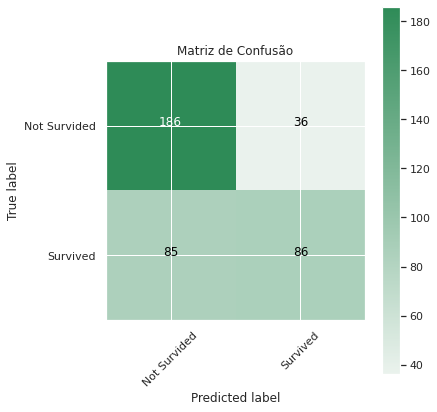

In [35]:
my_knn = KnnClassifier(k=5)
my_knn.fit(x_train, y_train)

classifier_evaluation(my_knn, x_test, y_test)

In [36]:
from sklearn.neighbors import KNeighborsClassifier

for k in [1, 3, 5, 10, 15, 20, x_train.shape[0]]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    prediction = knn.predict(x_test)
    print(f'Sklearn KNN with {k} neighbors: {accuracy_score(prediction, y_test)}')

Sklearn KNN with 1 neighbors: 0.6513994910941476
Sklearn KNN with 3 neighbors: 0.6895674300254453
Sklearn KNN with 5 neighbors: 0.6921119592875318
Sklearn KNN with 10 neighbors: 0.6615776081424937
Sklearn KNN with 15 neighbors: 0.6717557251908397
Sklearn KNN with 20 neighbors: 0.6564885496183206
Sklearn KNN with 916 neighbors: 0.5648854961832062


In [37]:
params = {
    'n_neighbors': [1, 3, 5, 6, 7, 8, 9, 10, 15, 20, x_train.shape[0]],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2],
}

choose_knn = model_selection.RandomizedSearchCV(KNeighborsClassifier(), params, cv=cv, scoring='accuracy', n_jobs=-1).fit(x_train, y_train)

print(f'best score: {choose_knn.best_score_}')
print(f'best params: {choose_knn.best_params_}')


best score: 0.7412318840579709
best params: {'weights': 'distance', 'p': 1, 'n_neighbors': 8, 'algorithm': 'auto'}


ROC Score: 0.6757942152678994
Accuracy Score: 0.6997455470737913
Average Precision Score: 0.5801841144514123
f1 Score: 0.5874125874125874
[[191  31]
 [ 87  84]]


/tmp/ipykernel_69285/218661130.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


0.6757942152678994

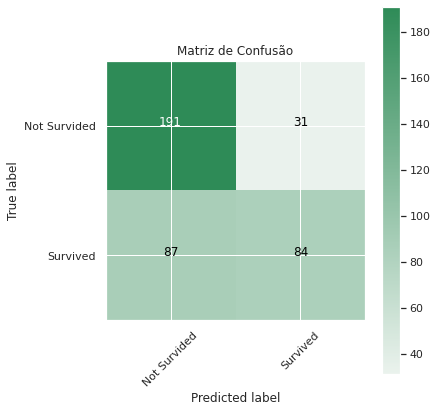

In [38]:
best_knn = KNeighborsClassifier(
    n_neighbors=choose_knn.best_params_['n_neighbors'],
    weights=choose_knn.best_params_['weights'],
    algorithm=choose_knn.best_params_['algorithm'],
    p=choose_knn.best_params_['p']
).fit(x_train, y_train)

classifier_evaluation(best_knn, x_test, y_test)

### Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression

params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000], 
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'multi_class': ['ovr', 'multinomial'],
}

choose_regression = model_selection.RandomizedSearchCV(LogisticRegression(), params, cv=cv, scoring='accuracy', n_jobs=-1).fit(x_train, y_train)

print(f'best score: {choose_regression.best_score_}')
print(f'best params: {choose_regression.best_params_}')

/home/gianlucca/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/gianlucca/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/gianlucca/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/gianlucca/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/gianlucca/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/gianlucca/.local/lib/python3.8/site-packages/sklearn/linear_mode

best score: 0.8221497584541064
best params: {'tol': 100, 'solver': 'lbfgs', 'penalty': 'l2', 'multi_class': 'multinomial', 'C': 100}


/home/gianlucca/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/gianlucca/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/gianlucca/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
140 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/home/gianlucca/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py"

ROC Score: 0.8570807649755017
Accuracy Score: 0.8575063613231552
Average Precision Score: 0.7678786030789081
f1 Score: 0.8390804597701148
[[191  31]
 [ 25 146]]


/tmp/ipykernel_69285/218661130.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


0.8570807649755017

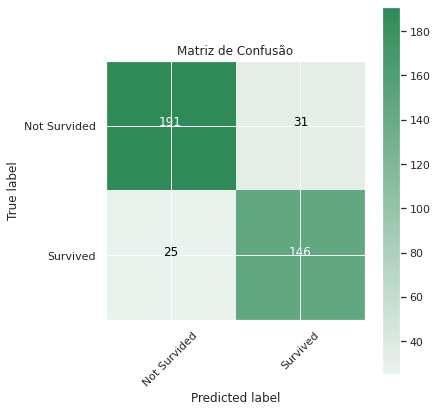

In [40]:
best_regression = LogisticRegression(
    penalty=choose_regression.best_estimator_.penalty,
    tol=choose_regression.best_estimator_.tol,
    C=choose_regression.best_estimator_.C,
    solver=choose_regression.best_estimator_.solver,
    multi_class=choose_regression.best_estimator_.multi_class,
    max_iter=10**6
).fit(x_train, y_train)

classifier_evaluation(best_regression, x_test, y_test)

ROC Score: 0.8721748063853326
Accuracy Score: 0.8753180661577609
Average Precision Score: 0.7980221439944221
f1 Score: 0.855457227138643
[[199  23]
 [ 26 145]]


/tmp/ipykernel_69285/218661130.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


0.8721748063853326

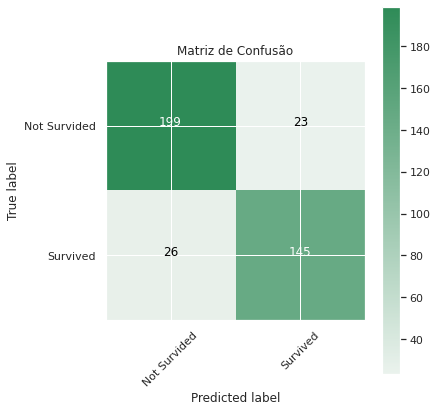

In [41]:
lr_nwt = LogisticRegression(solver='newton-cg', max_iter=10000).fit(x_train, y_train)

classifier_evaluation(lr_nwt, x_test, y_test)

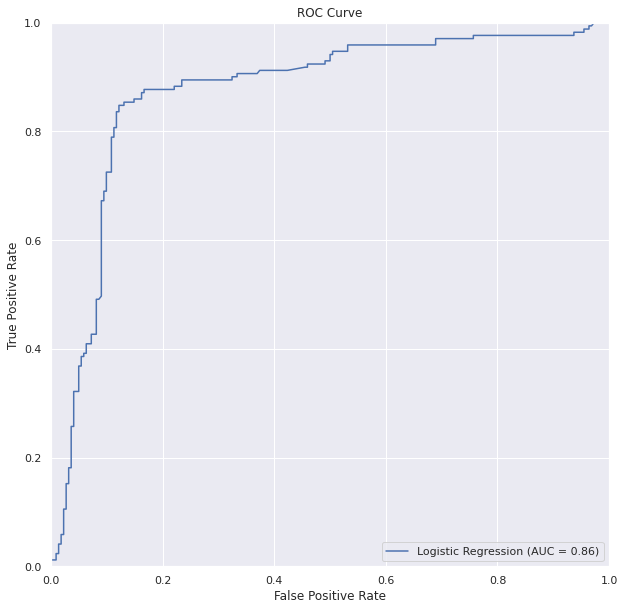

In [42]:
from sklearn.metrics import roc_curve

roc_auc = roc_auc_score(y_test, best_regression.predict(x_test))
fpr, tpr, _ = roc_curve(y_test, best_regression.predict_proba(x_test)[:, 1])

plt.figure()
plt.plot(fpr, tpr, label = 'Logistic Regression' + ' (AUC = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc = 'lower right')
plt.show()

### Support Vector Machine Classifier

In [43]:
from sklearn.svm import LinearSVC

linear_svc = LinearSVC(C=1, max_iter=10000).fit(x_train, y_train)
pred = linear_svc.predict(x_test)
print(f'Linear SVC: {accuracy_score(pred, y_test)}')

Linear SVC: 0.8524173027989822


/home/gianlucca/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [44]:
from sklearn.svm import SVC

for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    svc = SVC(kernel=kernel, max_iter=-1).fit(x_train, y_train)
    pred = svc.predict(x_test)
    print(f'SVC with {kernel} kernel: {accuracy_score(pred, y_test)}')

SVC with linear kernel: 0.8753180661577609
SVC with poly kernel: 0.6005089058524173
SVC with rbf kernel: 0.6183206106870229
SVC with sigmoid kernel: 0.6055979643765903


In [45]:
params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
    'C': np.linspace(0.1,3,7), 
    'degree': [2, 3, 4, 5],
    'gamma': np.logspace(-5, 0, 7)
}

# the following line of the code is commented because it runs for too much time (some hours hehe)
# the results are kernel = 'linear', c = 3.0, degree = 5 and gamma = 0.021544346900318846, with an accuracy of 0.8460441910192446
# choose_sgd = model_selection.RandomizedSearchCV(SVC(), params, cv=5, scoring='accuracy', n_jobs=-1).fit(x_train, y_train)

# print(f'best accuracy: {choose_sgd.best_score_}')
# print(f'best params: {choose_sgd.best_params_}')

Construindo um modelo com os melhores parâmetros:

ROC Score: 0.8728465307412675
Accuracy Score: 0.8753180661577609
Average Precision Score: 0.7968777654358917
f1 Score: 0.8563049853372433
[[198  24]
 [ 25 146]]


/tmp/ipykernel_69285/218661130.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


0.8728465307412675

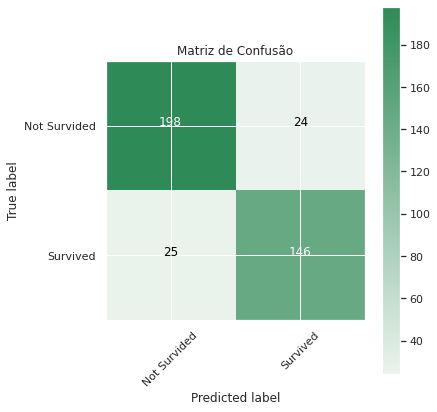

In [46]:
best_svc = SVC(
    kernel='linear', 
    C=3.0, 
    degree=5, 
    gamma=0.021544346900318846,
    max_iter=-1,
    shrinking=True,
    tol=0.001,
    probability=False,
    cache_size=200,
    random_state=0
).fit(x_train, y_train)

classifier_evaluation(best_svc, x_test, y_test)

### SGD

In [47]:
from sklearn.linear_model import SGDClassifier

params = {
    'loss': [
            'hinge', 
            'log_loss', 
            'log', 
            'modified_huber', 
            'squared_hinge', 
            'perceptron', 
            'squared_error', 
            'huber',
            'epsilon_insensitive', 
            'squared_epsilon_insensitive'
    ],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': np.logspace(-5, 0, 7),
    'shuffle': [True, False],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
}

choose_sgd = model_selection.RandomizedSearchCV(SGDClassifier(), params, cv=5, scoring='accuracy', n_jobs=-1, random_state=None).fit(x_train, y_train);

print(f'best accuracy: {choose_sgd.best_score_}')
print(f'best params: {choose_sgd.best_params_}')


best accuracy: 0.6866179615110477
best params: {'shuffle': False, 'penalty': 'l2', 'loss': 'perceptron', 'learning_rate': 'optimal', 'alpha': 0.0004641588833612782}


/home/gianlucca/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/home/gianlucca/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/gianlucca/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "/home/gianlucca/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py", line 649, in _fit
    self._validate_params

ROC Score: 0.6115457562825983
Accuracy Score: 0.6590330788804071
Average Precision Score: 0.5477291572279732
f1 Score: 0.38532110091743116
[[217   5]
 [129  42]]


/tmp/ipykernel_69285/218661130.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


0.6115457562825983

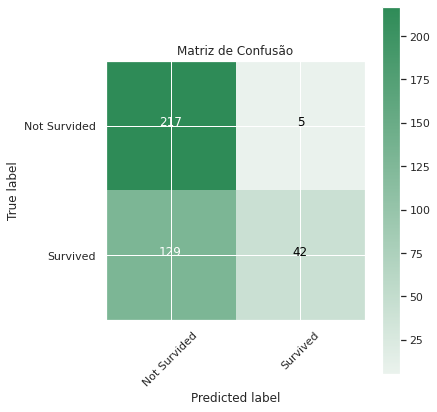

In [48]:
best_sgd = SGDClassifier(
    loss= choose_sgd.best_estimator_.loss, 
    penalty=choose_sgd.best_estimator_.penalty,
    alpha=choose_sgd.best_estimator_.alpha,
    shuffle=choose_sgd.best_estimator_.shuffle,
    learning_rate=choose_sgd.best_estimator_.learning_rate,
    max_iter=10**6,
    tol=0.001,
).fit(x_train, y_train)

classifier_evaluation(best_sgd, x_test, y_test)

### Gaussian Mixture

In [49]:
from sklearn.gaussian_process import GaussianProcessClassifier

params = {
    'optimizer': ['fmin_l_bfgs_b', 'lbfgs', 'sgd', 'rmsprop', 'adam'],
    'n_restarts_optimizer': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
}

choose_gaussian = model_selection.RandomizedSearchCV(GaussianProcessClassifier(), params, cv=5, scoring='accuracy', n_jobs=-1).fit(x_train, y_train)

print(f'best accuracy: {choose_gaussian.best_score_}')
print(f'best params: {choose_gaussian.best_params_}')

best accuracy: 0.6800962223806131
best params: {'optimizer': 'sgd', 'n_restarts_optimizer': 7}


ROC Score: 0.6739766081871346
Accuracy Score: 0.6946564885496184
Average Precision Score: 0.5734883264139994
f1 Score: 0.5945945945945945
[[185  37]
 [ 83  88]]


/tmp/ipykernel_69285/218661130.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


0.6739766081871346

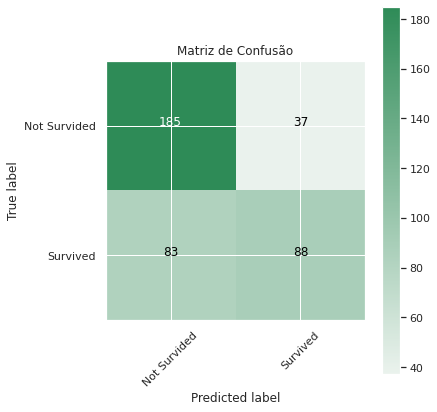

In [50]:
best_gaussian = GaussianProcessClassifier(
    optimizer=choose_gaussian.best_estimator_.optimizer,
    n_restarts_optimizer=choose_gaussian.best_estimator_.n_restarts_optimizer,
).fit(x_train, y_train)

classifier_evaluation(best_gaussian, x_test, y_test)

### Decision Tree

In [51]:
from sklearn.tree import DecisionTreeClassifier

params = {
    'criterion': ['gini', 'entropy', 'los_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
}

choose_decision_tree = model_selection.RandomizedSearchCV(DecisionTreeClassifier(), params, cv=5, scoring='accuracy', n_jobs=-1).fit(x_train, y_train)

print(f'best accuracy: {choose_decision_tree.best_score_}')
print(f'best params: {choose_decision_tree.best_params_}')

best accuracy: 0.8460441910192446
best params: {'splitter': 'random', 'min_weight_fraction_leaf': 0.2, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_depth': 5, 'criterion': 'gini'}


/home/gianlucca/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/gianlucca/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/gianlucca/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/home/gianlucca/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 304, in fit
    raise ValueError("min_weight_fraction_leaf must in [0, 0.5]")
Value

ROC Score: 0.8728465307412675
Accuracy Score: 0.8753180661577609
Average Precision Score: 0.7968777654358917
f1 Score: 0.8563049853372433
[[198  24]
 [ 25 146]]


/tmp/ipykernel_69285/218661130.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


0.8728465307412675

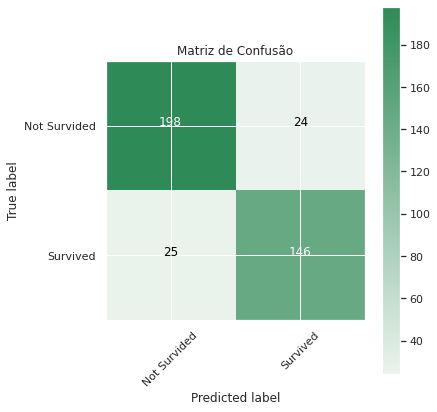

In [61]:
best_decision_tree = DecisionTreeClassifier(
    criterion=choose_decision_tree.best_estimator_.criterion,
    splitter=choose_decision_tree.best_estimator_.splitter,
    max_depth=choose_decision_tree.best_estimator_.max_depth,
    min_samples_split=choose_decision_tree.best_estimator_.min_samples_split,
    min_samples_leaf=choose_decision_tree.best_estimator_.min_samples_leaf,
    min_weight_fraction_leaf=choose_decision_tree.best_estimator_.min_weight_fraction_leaf,
).fit(x_train, y_train)

classifier_evaluation(best_decision_tree, x_test, y_test)

|--- Sex_male <= 0.06
|   |--- class: 1
|--- Sex_male >  0.06
|   |--- Pclass <= 2.13
|   |   |--- class: 0
|   |--- Pclass >  2.13
|   |   |--- class: 0



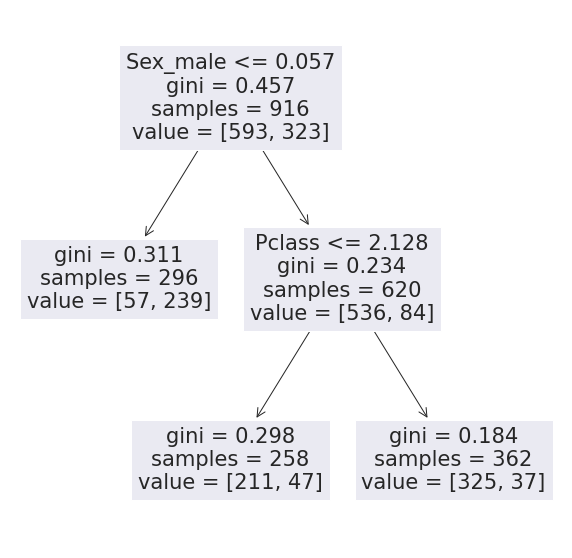

In [64]:
from sklearn.tree import export_text
from sklearn.tree import plot_tree

print(export_text(best_decision_tree, feature_names=x_train.columns.to_list(), max_depth=2))
plot_tree(best_decision_tree, feature_names=x_train.columns.to_list(), max_depth=2);


ROC Score: 0.8591354512407143
Accuracy Score: 0.8651399491094147
Average Precision Score: 0.7876018369715637
f1 Score: 0.8398791540785498
[[201  21]
 [ 32 139]]


/tmp/ipykernel_69285/218661130.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


0.8591354512407143

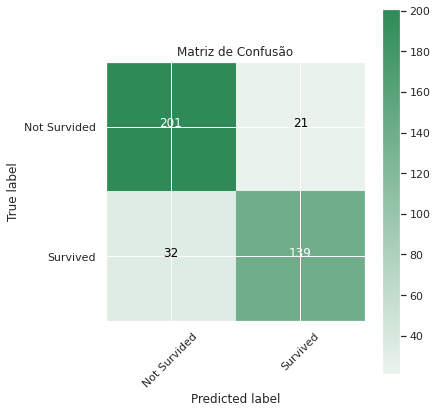

In [72]:
tree = DecisionTreeClassifier().fit(x_train, y_train)

classifier_evaluation(tree, x_test, y_test)

|--- Sex_male <= 0.50
|   |--- Pclass <= 2.50
|   |   |--- Age <= 2.50
|   |   |   |--- truncated branch of depth 2
|   |   |--- Age >  2.50
|   |   |   |--- truncated branch of depth 8
|   |--- Pclass >  2.50
|   |   |--- Fare <= 23.35
|   |   |   |--- truncated branch of depth 20
|   |   |--- Fare >  23.35
|   |   |   |--- truncated branch of depth 7
|--- Sex_male >  0.50
|   |--- Age <= 3.50
|   |   |--- SibSp <= 2.00
|   |   |   |--- truncated branch of depth 5
|   |   |--- SibSp >  2.00
|   |   |   |--- truncated branch of depth 2
|   |--- Age >  3.50
|   |   |--- Pclass <= 1.50
|   |   |   |--- truncated branch of depth 14
|   |   |--- Pclass >  1.50
|   |   |   |--- truncated branch of depth 18



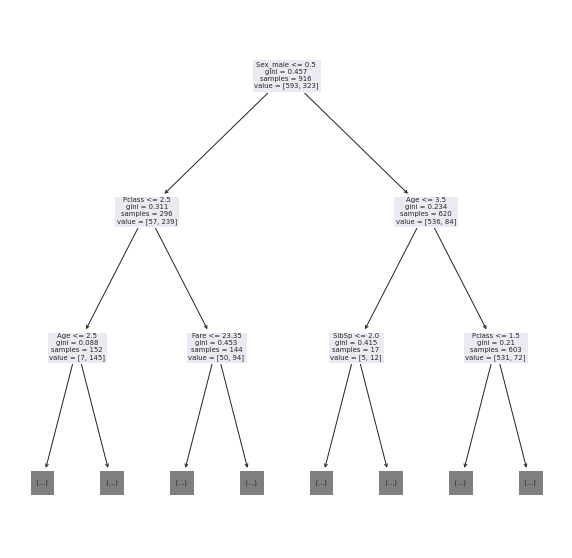

In [73]:
print(export_text(tree, feature_names=x_train.columns.to_list(), max_depth=2))
plot_tree(tree, feature_names=x_train.columns.to_list(), max_depth=2);

### Random Forest

In [75]:
from sklearn.ensemble import RandomForestClassifier

params = {
    'n_estimators': [10, 25, 50, 75, 100, 200, 500, 1000],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20],
    'bootstrap': [True, False],
    'max_features': ['auto', 'sqrt', 'log2'],
}

choose_random_forest = model_selection.RandomizedSearchCV(RandomForestClassifier(), params, cv=5, scoring='accuracy', n_jobs=-1).fit(x_train, y_train)

print(f'best accuracy: {choose_random_forest.best_score_}')
print(f'best params: {choose_random_forest.best_params_}')

/home/gianlucca/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/gianlucca/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/gianlucca/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 442, in fit
    trees = Parallel(
  File "/home/gianlucca/.local/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/gianluc

best accuracy: 0.8526075077215489
best params: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': False}


ROC Score: 0.8766793108898373
Accuracy Score: 0.8804071246819338
Average Precision Score: 0.8068397871652675
f1 Score: 0.8605341246290802
[[201  21]
 [ 26 145]]


/tmp/ipykernel_69285/218661130.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


0.8766793108898373

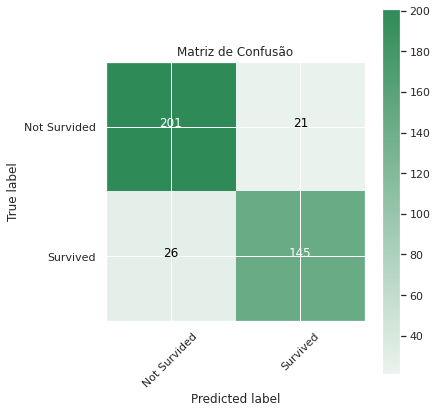

In [76]:
best_random_forest = RandomForestClassifier(
    n_estimators=choose_random_forest.best_estimator_.n_estimators,
    criterion=choose_random_forest.best_estimator_.criterion,
    max_depth=choose_random_forest.best_estimator_.max_depth,
    bootstrap=choose_random_forest.best_estimator_.bootstrap,
    max_features=choose_random_forest.best_estimator_.max_features,
    n_jobs=-1,    
).fit(x_train, y_train)

classifier_evaluation(best_random_forest, x_test, y_test)

### Perceptron

In [ ]:
from sklearn.linear_model import Perceptron

params = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': np.logspace(-5, 0, 7),
    'shuffle': [True, False],    
}

choose_perceptron = model_selection.RandomizedSearchCV(Perceptron(), params, cv=5, scoring='accuracy', n_jobs=-1).fit(x_train, y_train)

print(f'best accuracy: {choose_perceptron.best_score_}')
print(f'best params: {choose_perceptron.best_params_}')

best accuracy: 0.8493228795438347
best params: {'shuffle': False, 'penalty': 'l1', 'alpha': 0.021544346900318846}


ROC Score: 0.8724118855697803
Accuracy Score: 0.8778625954198473
Average Precision Score: 0.806202085587905
f1 Score: 0.8554216867469879
[[203  19]
 [ 29 142]]


/tmp/ipykernel_46123/218661130.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


0.8724118855697803

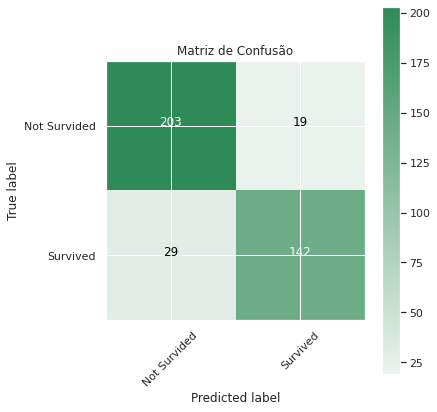

In [ ]:
best_perceptron = Perceptron(
    penalty=choose_perceptron.best_estimator_.penalty,
    alpha=choose_perceptron.best_estimator_.alpha,
    shuffle=choose_perceptron.best_estimator_.shuffle,
    max_iter=10**6,
    tol=0.001,
).fit(x_train, y_train)

classifier_evaluation(best_perceptron, x_test, y_test)

## 3. Avaliação Parcial dos Resultados

In [ ]:
def eval_dataframe(models):
        
    df_results = pd.DataFrame(columns=['model_name', 'accuracy','precision', 'recall', 'f1', 'roc_auc'])

    for model in models:
        predictions = models[model].predict(x_test)

        accuracy = accuracy_score(y_test, predictions)
        precision = precision_score(y_test, predictions)
        recall = recall_score(y_test, predictions)
        f1_score_ = f1_score(y_test, predictions)
        roc_auc = roc_auc_score(y_test, predictions)

        df_results = df_results.append({'model_name': model, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1_score_, 'roc_auc': roc_auc}, ignore_index=True)

    return df_results.sort_values(by=['accuracy', 'f1'], ascending=False)

In [ ]:
models = {
    'KNN': best_knn,
    'logistic regression': best_regression,
    'SVM': best_svc,
    'SGD': best_sgd,
    'Gaussian Process': best_gaussian,
    'Decision Tree': best_decision_tree,
    'Random Forest': best_random_forest,
    'Perceptron': best_perceptron,
}

df_results = eval_dataframe(models)
df_results

,model_name,accuracy,precision,recall,f1,roc_auc
6,Random Forest,0.885496,0.884146,0.847953,0.865672,0.881184
5,Decision Tree,0.880407,0.897436,0.818713,0.856269,0.873321
7,Perceptron,0.877863,0.881988,0.830409,0.855422,0.872412
2,SVM,0.875318,0.858824,0.853801,0.856305,0.872847
1,logistic regression,0.865140,0.839080,0.853801,0.846377,0.863838
4,Gaussian Process,0.694656,0.704000,0.514620,0.594595,0.673977
0,KNN,0.681934,0.730000,0.426901,0.538745,0.652639
3,SGD,0.567430,1.000000,0.005848,0.011628,0.502924
